## Assignment 01. Simple text processing.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from IPython import display

In [2]:
%load_ext autoreload
%autoreload 2

### Toxic or not
Your main goal in this assignment is to classify, whether the comments are toxic or not. And practice with both classical approaches and PyTorch in the process.

*Credits: This homework is inspired by YSDA NLP_course.*

In [3]:
# In colab run this cell
! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/homeworks_advanced/assignment1_01_Word_Vectors/utils.py -nc
! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/homeworks_advanced/assignment1_01_Word_Vectors/features.py -nc

File ‘utils.py’ already there; not retrieving.

File ‘features.py’ already there; not retrieving.



In [4]:
try:
    data = pd.read_csv('../../datasets/comments_small_dataset/comments.tsv', sep='\t')
except FileNotFoundError:
    ! wget https://raw.githubusercontent.com/girafe-ai/ml-mipt/advanced_f20/datasets/comments_small_dataset/comments.tsv -nc
    data = pd.read_csv("comments.tsv", sep='\t')

File ‘comments.tsv’ already there; not retrieving.



In [5]:
texts = data['comment_text'].values
target = data['should_ban'].values
data[50::200]

,should_ban,comment_text
50,0,"""Those who're in advantageous positions are th..."
250,1,Fartsalot56 says f**k you motherclucker!!
450,1,"Are you a fool? \n\nI am sorry, but you seem t..."
650,1,I AM NOT A VANDAL!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
850,0,Citing sources\n\nCheck out the Wikipedia:Citi...


In [6]:
from sklearn.model_selection import train_test_split
texts_train, texts_test, y_train, y_test = train_test_split(texts, target, test_size=0.5, random_state=42)

__Note:__ it is generally a good idea to split data into train/test before anything is done to them.

It guards you against possible data leakage in the preprocessing stage. For example, should you decide to select words present in obscene tweets as features, you should only count those words over the training set. Otherwise your algoritm can cheat evaluation.

### Preprocessing and tokenization

Comments contain raw text with punctuation, upper/lowercase letters and even newline symbols.

To simplify all further steps, we'll split text into space-separated tokens using one of nltk tokenizers.

Generally, library `nltk` [link](https://www.nltk.org) is widely used in NLP. It is not necessary in here, but mentioned to intoduce it to you.

In [7]:
from nltk.tokenize import TweetTokenizer
tokenizer = TweetTokenizer()
preprocess = lambda text: ' '.join(tokenizer.tokenize(text.lower()))

text = 'How to be a grown-up at work: replace "I don\'t want to do that" with "Ok, great!".'
print("before:", text,)
print("after:", preprocess(text),)

before: How to be a grown-up at work: replace "I don't want to do that" with "Ok, great!".
after: how to be a grown-up at work : replace " i don't want to do that " with " ok , great ! " .


In [8]:
# task: preprocess each comment in train and test

vect_preprocess = np.vectorize(preprocess)#<YOUR CODE>
texts_train = vect_preprocess(texts_train)#<YOUR CODE>
texts_test = vect_preprocess(texts_test)#<YOUR CODE>

In [9]:
# Small check that everything is done properly
assert texts_train[5] ==  'who cares anymore . they attack with impunity .'
assert texts_test[89] == 'hey todds ! quick q ? why are you so gay'
assert len(texts_test) == len(y_test)

### Step 1: bag of words

One traditional approach to such problem is to use bag of words features:
1. build a vocabulary of frequent words (use train data only)
2. for each training sample, count the number of times a word occurs in it (for each word in vocabulary).
3. consider this count a feature for some classifier

__Note:__ in practice, you can compute such features using sklearn. __Please don't do that in the current assignment, though.__
* `from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer`

In [10]:
from features import BoW

# task: find up to k most frequent tokens in texts_train,
# sort them by number of occurences (highest first)
k = min(10000, len(set(' '.join(texts_train).split())))

#<YOUR CODE>
bow = BoW(k)
bow.fit(texts_train)

print('example features:', sorted(bow.get_vocabulary())[::100])

example features: ['!', '12:20', '300', '_', 'adorned', 'alternative', 'archive', 'average', 'benkner', 'bout', 'came', 'chest', 'combined', 'consumers', 'cricket', 'decisions', 'dickheads', 'domestic', 'eductaion', 'essentially', 'faggot', 'firms', 'frustrated', 'goal', 'hanibal', 'hip-hop', 'identified', 'infoboxes', 'issue', 'kindergarten', 'lets', 'lot', "mclaren's", 'moderator', 'naturally', 'noticeable', 'opposing', 'pdf', 'plant', 'pretoria', 'punctuation', 'rebels', 'repetative', 'riadh', 'schulz', 'shes', 'slit', 'spoof', 'stupid', 't', 'theoretical', 'topic', 'uglyness', 'userspace', 'wanted', 'wikieditor', 'year', 'ீ']


In [11]:
X_train_bow = bow.transform(texts_train)
X_test_bow = bow.transform(texts_test)

In [12]:
# Small check that everything is done properly
bow_vocabulary = bow.get_vocabulary()
k_max = len(set(' '.join(texts_train).split()))
assert X_train_bow.shape == (len(texts_train), min(k, k_max))
assert X_test_bow.shape == (len(texts_test), min(k, k_max))
assert np.all(X_train_bow[5:10].sum(-1) == np.array([len(s.split()) for s in  texts_train[5:10]]))
assert len(bow_vocabulary) <= min(k, k_max)
assert X_train_bow[6, bow_vocabulary.index('.')] == texts_train[6].split().count('.')

Now let's do the trick with `sklearn` logistic regression implementation:

In [13]:
from sklearn.linear_model import LogisticRegression
bow_model = LogisticRegression().fit(X_train_bow, y_train)

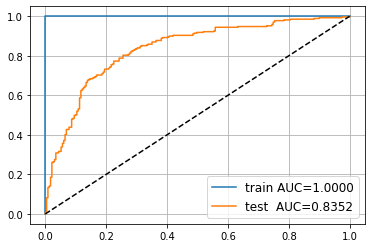

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow, y_train, bow_model),
    ('test ', X_test_bow, y_test, bow_model)
]:
    proba = model.predict_proba(X)[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Seems alright. Now let's create the simple logistic regression using PyTorch. Just like in the classwork.

In [15]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau

from sklearn.metrics import accuracy_score

In [16]:
from utils import plot_train_process

In [17]:
model = nn.Sequential()

model.add_module('l1', nn.Linear(k, 2))### YOUR CODE HERE
model.add_module('log_softmax', nn.LogSoftmax(dim=1))### YOUR CODE HERE

Remember what we discussed about loss functions! `nn.CrossEntropyLoss` combines both log-softmax and `NLLLoss`.

__Be careful with it! Criterion `nn.CrossEntropyLoss` with still work with log-softmax output, but it won't allow you to converge to the optimum.__ Next comes small demonstration:

In [18]:
loss_function = nn.NLLLoss()
#loss_function = nn.CrossEntropyLoss()

In [19]:
opt = torch.optim.Adam(model.parameters())### YOUR CODE HERE

In [20]:
lr_scheduler = ReduceLROnPlateau(opt, 'min')

In [21]:
X_train_bow_torch = torch.tensor(X_train_bow)### YOUR CODE HERE
X_test_bow_torch = torch.tensor(X_test_bow)### YOUR CODE HERE

y_train_torch = torch.tensor(y_train)### YOUR CODE HERE
y_test_torch = torch.tensor(y_test)### YOUR CODE HERE

Let's test that everything is fine

In [22]:
# example loss
loss = loss_function(model(X_train_bow_torch[:3]), y_train_torch[:3])

In [23]:
assert type(loss.item()) == float

Here comes small function to train the model. In future we will take in into separate file, but for this homework it's ok to implement it here. 

In [24]:
def train_model(
    model,
    opt,
    lr_scheduler,
    loss_function,
    X_train_torch,
    y_train_torch,
    X_val_torch,
    y_val_torch,
    n_iterations=500,
    batch_size=32,
    warm_start=False,
    show_plots=True,
    eval_every=10
):
#     if not warm_start:
#         for name, module in model.named_children():
#             print('resetting ', name)
#             try:
#                 module.reset_parameters()
#             except AttributeError as e:
#                 print('Cannot reset {} module parameters: {}'.format(name, e))

    train_loss_history = []
    train_acc_history = []
    val_loss_history = []
    val_acc_history = []

    local_train_loss_history = []
    local_train_acc_history = []
    for i in range(n_iterations):
        
        # clear gradients
        opt.zero_grad()### YOUR CODE

        # sample 256 random observations
        ix = np.random.randint(0, len(X_train_torch), batch_size)
        x_batch = X_train_torch[ix]
        y_batch = y_train_torch[ix]

        # predict log-probabilities or logits
        y_predicted = model(x_batch)### YOUR CODE

        # compute loss, just like before
        loss = loss_function(y_predicted, y_batch)### YOUR CODE

        # compute gradients
        loss.backward()### YOUR CODE

        # Adam step
        opt.step()### YOUR CODE


        local_train_loss_history.append(loss.data.numpy())
        local_train_acc_history.append(
            accuracy_score(
                y_batch.to('cpu').detach().numpy(),
                y_predicted.to('cpu').detach().numpy().argmax(axis=1)
            )
        )

        if i % eval_every == 0:
            train_loss_history.append(np.mean(local_train_loss_history))
            train_acc_history.append(np.mean(local_train_acc_history))
            local_train_loss_history, local_train_acc_history = [], []

            predictions_val = model(X_val_torch)
            val_loss_history.append(loss_function(predictions_val, y_val_torch).to('cpu').detach().item())

            acc_score_val = accuracy_score(y_val_torch.cpu().numpy(), predictions_val.to('cpu').detach().numpy().argmax(axis=1))
            val_acc_history.append(acc_score_val)
            lr_scheduler.step(train_loss_history[-1])

            if show_plots:
                display.clear_output(wait=True)
                plot_train_process(train_loss_history, val_loss_history, train_acc_history, val_acc_history)
    return model

Let's run it on the data. Note, that here we use the `test` part of the data for validation. It's not so good idea in general, but in this task our main goal is practice.

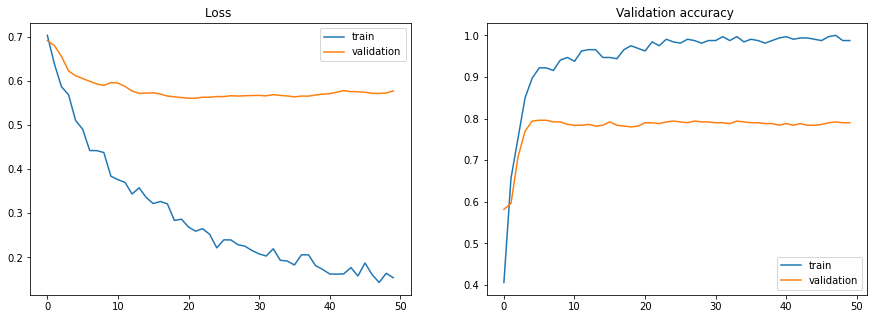

Sequential(
  (l1): Linear(in_features=5722, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)

In [25]:
train_model(model, opt, lr_scheduler, loss_function, X_train_bow_torch, y_train_torch, X_test_bow_torch, y_test_torch)

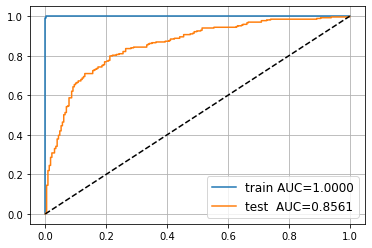

In [26]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_bow_torch, y_train, model),
    ('test ', X_test_bow_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

Try to vary the number of tokens `k` and check how the model performance changes. Show it on a plot.

In [27]:
# Your beautiful code here

In [28]:
k_max = min(10000, len(set(' '.join(texts_train).split())))

In [29]:
k_max

5722

**<font color=blue>Observations:</font>**

- We'll try values for `k` in the range $[1000, 5000]$ by steps of $1000$.

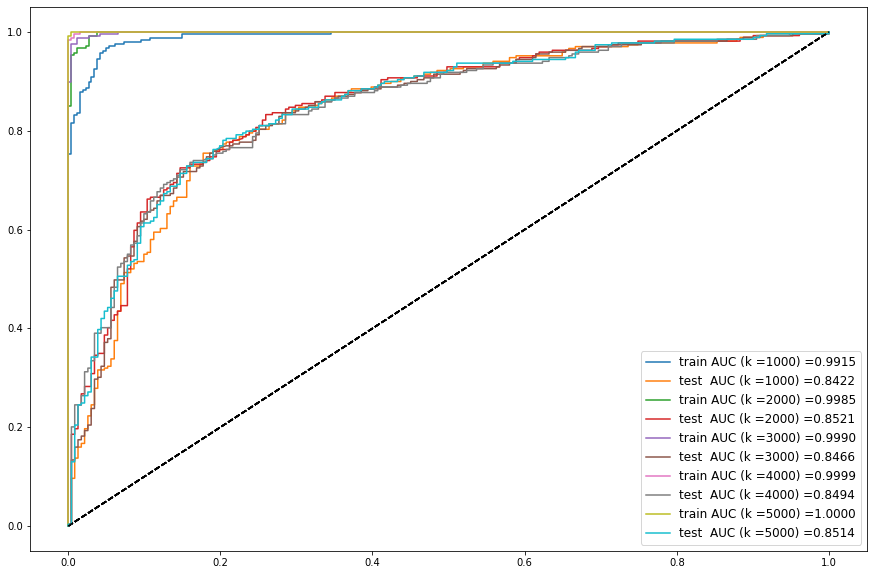

In [30]:
plt.figure(figsize=(15,10))
for k0 in range(1000, k_max, 1000):
    bow_k = BoW(k0)
    bow_k.fit(texts_train)
    
    X_train_bow_k = bow_k.transform(texts_train)
    X_test_bow_k = bow_k.transform(texts_test)
    
    
    model_k = nn.Sequential()
    model_k.add_module('l1', nn.Linear(k0, 2))### YOUR CODE HERE
    model_k.add_module('log_softmax', nn.LogSoftmax(dim=1))### YOUR CODE HERE
    loss_function_k = nn.NLLLoss()
    opt_k = torch.optim.Adam(model_k.parameters())### YOUR CODE HERE
    lr_scheduler_k = ReduceLROnPlateau(opt_k, 'min')
    
    X_train_bow_k_torch = torch.tensor(X_train_bow_k)### YOUR CODE HERE
    X_test_bow_k_torch = torch.tensor(X_test_bow_k)### YOUR CODE HERE
    
    trained_model = train_model(
        model_k,
        opt_k,
        lr_scheduler_k,
        loss_function_k,
        X_train_bow_k_torch,
        y_train_torch,
        X_test_bow_k_torch,
        y_test_torch,
        show_plots=False
        )
    
#     proba = model_k(X_test_bow_k_torch).detach().cpu().numpy()[:, 1]
#     auc = roc_auc_score(y_test, proba)
#     plt.plot(*roc_curve(y_test, proba)[:2], label='%s AUC (k =%s) =%.4f' % (name, k0, auc))
#     plt.plot([0, 1], [0, 1], '--', color='black',)
#     plt.legend(fontsize='large')
#     plt.grid()

    for name, X, y, model in [
    ('train', X_train_bow_k_torch, y_train, model_k),
    ('test ', X_test_bow_k_torch, y_test, model_k)
]:
        proba = model_k(X).detach().cpu().numpy()[:, 1]
        auc = roc_auc_score(y, proba)
        plt.plot(*roc_curve(y, proba)[:2], label='%s AUC (k =%s) =%.4f' % (name, k0, auc))

        plt.plot([0, 1], [0, 1], '--', color='black',)
        plt.legend(fontsize='large')
        plt.grid()

**<font color=blue>Conclusions:</font>**

- We don't observe any conclusive dependence of AUC test score on the number of tokens `k` in the vocabulary.
- A better conclusion requires a more thorough experiment, like repeating the training for each different value of `k` several time and taking the average of the AUC score. For the sake of time/simplicity we don't do that here.  
- **Expected behaviour:** As $k$ gets lower (the vocabulary gets smaller) the train AUC score decreases as well. This would make sense since, according to our implementation of `transform` and `_text_to_word`, the smaller the vocabulary, less word are in the vocabulary and the more words we ignore we creating BoW.
- **But:** The test score does not have significant changes wrt to $k$. This may be related to the fact that in the vocabulary we keep only the $k$ most common words, which may be the less informative ones (like english articles, connectives, prepositions, etc.). Reducing the vocabulary size doesn't add up too much, since we already drop the less common words (which may be the more informative ones).

### Step 2: implement TF-IDF features

Not all words are equally useful. One can prioritize rare words and downscale words like "and"/"or" by using __tf-idf features__. This abbreviation stands for __text frequency/inverse document frequence__ and means exactly that:

$$ feature_i = { Count(word_i \in x) \times { log {N \over Count(word_i \in D) + \alpha} }}, $$


where x is a single text, D is your dataset (a collection of texts), N is a total number of documents and $\alpha$ is a smoothing hyperparameter (typically 1). 
And $Count(word_i \in D)$ is the number of documents where $word_i$ appears.

It may also be a good idea to normalize each data sample after computing tf-idf features.

__Your task:__ implement tf-idf features, train a model and evaluate ROC curve. Compare it with basic BagOfWords model from above.

__Please don't use sklearn/nltk builtin tf-idf vectorizers in your solution :)__ You can still use 'em for debugging though.

Blog post about implementing the TF-IDF features from scratch: https://triton.ml/blog/tf-idf-from-scratch

In [31]:
from features import TfIdf

# Your beautiful code here

In [32]:
tf_idf = TfIdf(normalize=True)
tf_idf.fit(texts_train)

In [33]:
X_train_tfidf = tf_idf.transform(texts_train)
X_test_tfidf = tf_idf.transform(texts_test)

Same stuff about moel and optimizers here (or just omit it, if you are using the same model as before).

In [34]:
### YOUR CODE HERE

In [35]:
model = nn.Sequential()

#model.add_module('l1', nn.Linear(k+1, 2))### YOUR CODE HERE
model.add_module('l1', nn.Linear(k, 2))
model.add_module('log_softmax', nn.LogSoftmax(dim=1))### YOUR CODE HERE

In [36]:
loss_function = nn.NLLLoss()
#loss_function = nn.CrossEntropyLoss()

In [37]:
opt = torch.optim.Adam(model.parameters())### YOUR CODE HERE

In [38]:
lr_scheduler = ReduceLROnPlateau(opt, 'min')

In [39]:
X_train_tfidf_torch = torch.tensor(X_train_tfidf, dtype=torch.float)### YOUR CODE HERE
X_test_tfidf_torch = torch.tensor(X_test_tfidf, dtype=torch.float)### YOUR CODE HERE

y_train_torch = torch.tensor(y_train)### YOUR CODE HERE
y_test_torch = torch.tensor(y_test)### YOUR CODE HERE

Fit your model to the data. No not hesitate to vary number of iterations, learning rate and so on.

_Note: due to very small dataset, increasing the complexity of the network might not be the best idea._

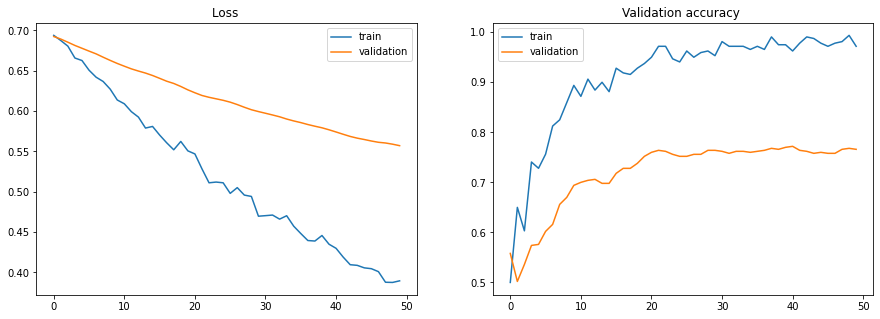

Sequential(
  (l1): Linear(in_features=5722, out_features=2, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)

In [40]:
train_model(model, opt, lr_scheduler, loss_function, X_train_tfidf_torch, y_train_torch, X_test_tfidf_torch, y_test_torch)

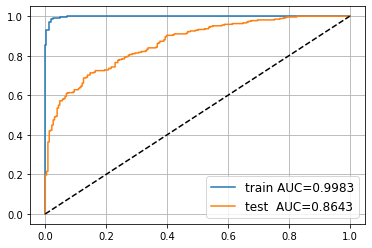

In [41]:
from sklearn.metrics import roc_auc_score, roc_curve

for name, X, y, model in [
    ('train', X_train_tfidf_torch, y_train, model),
    ('test ', X_test_tfidf_torch, y_test, model)
]:
    proba = model(X).detach().cpu().numpy()[:, 1]
    auc = roc_auc_score(y, proba)
    plt.plot(*roc_curve(y, proba)[:2], label='%s AUC=%.4f' % (name, auc))

plt.plot([0, 1], [0, 1], '--', color='black',)
plt.legend(fontsize='large')
plt.grid()

**<font color=blue>Conclusions:</font>**

- Tf-Idf does slightly better than BoW. This may be related to the fact that this method keeps sentence information "smarter" than BoW does. That is, by giving more importance to less common words and atenuating the effect of common ones.

### Step 3: Comparing it with Naive Bayes

Naive Bayes classifier is a good choice for such small problems. Try to tune it for both BOW and TF-iDF features. Compare the results with Logistic Regression.

In [42]:
# Your beautiful code here

In [43]:
from sklearn.neighbors import KNeighborsClassifier

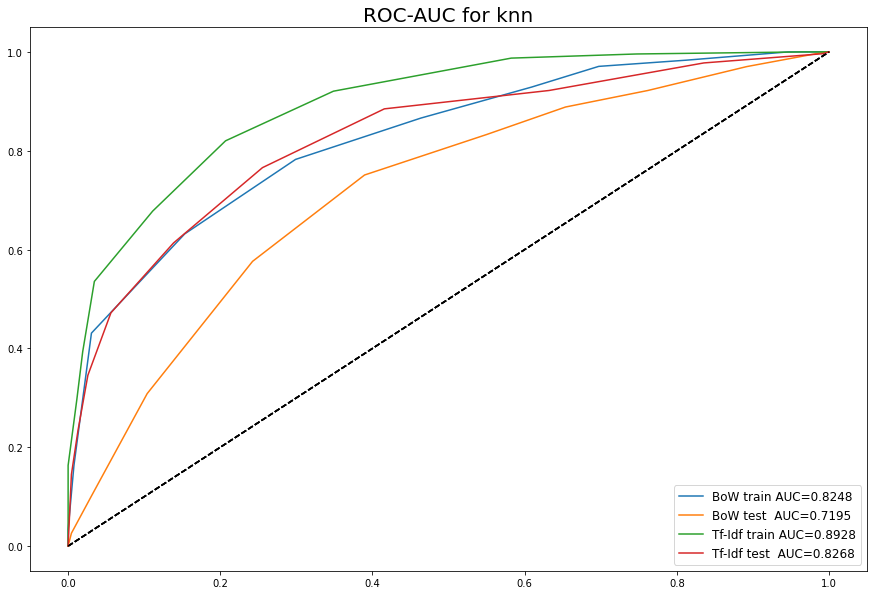

In [44]:
plt.figure(figsize=(15,10))
plt.title('ROC-AUC for knn', fontsize=20)
for name, X_train_, X_test_ in [
    ('BoW', X_train_bow, X_test_bow),
    ('Tf-Idf', X_train_tfidf, X_test_tfidf)
]:
    knn = KNeighborsClassifier(n_neighbors = 10)
    knn.fit(X_train_, y_train)
    
    for set_name, X, y, model in [
    ('train', X_train_, y_train, knn),
    ('test ', X_test_, y_test, knn)
]:
        proba = model.predict_proba(X)[:, 1]
        auc = roc_auc_score(y, proba)
        plt.plot(*roc_curve(y, proba)[:2], label='%s %s AUC=%.4f' % (name, set_name, auc))

        plt.plot([0, 1], [0, 1], '--', color='black',)
        plt.legend(fontsize='large', loc='lower right')
        plt.grid()

Shape some thoughts on the results you aquired. Which model has show the best performance? Did changing the learning rate/lr scheduler help?

_Your beautiful thoughts here_

**<font color=blue>Conclusions:</font>**

- The model with Tf-Idf show better performance on both the train and test sets.
- This is the expected result, considering the advantages that Tf-Idf has over BoW when dealing with uncommon words.
- There was no hyperparameter other that the number of neighbors, since we used knn out-of-the-box from `sklearn`.
- The comparison with Logistic Regression requested above is dealt with below.

### Step 4: Using the external knowledge.

Use the `gensim` word2vec pretrained model to translate words into vectors. Use several models with this new encoding technique. Compare the results, share your thoughts.

In [45]:
# Your beautiful code here

In [46]:
import gensim.downloader as api
model = api.load('glove-twitter-25')

[==================================================] 100.0% 104.8/104.8MB downloaded


In [47]:
class MeanEmbeddingVectorizer():
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.dim = len(word2vec.index2word)
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return np.array([
            np.mean([self.word2vec[w] for w in words 
                     if w in self.word2vec] or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [48]:
vectorizer = MeanEmbeddingVectorizer(model)

In [49]:
texts_train_tok = [tokenizer.tokenize(string) for string in texts_train]
texts_test_tok = [tokenizer.tokenize(string) for string in texts_test]

In [50]:
X_train = vectorizer.transform(texts_train_tok)
X_test = vectorizer.transform(texts_test_tok)

In [51]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC

**<font color=blue>Observations</font>**

- The dataset is not big, so we'll avoid using any fancy model (maybe with the exception of Extra Trees :P).
- Models used:
  - Extra Trees.
  - SVC.
  - Logistic Regression.
  - KNN.

- Metric used:
  - Accuracy.

In [52]:
models = {
    'extra_trees' : ExtraTreesClassifier(n_estimators=200),
    'svc' : SVC(kernel="linear"),
    'log_reg' : LogisticRegression(),
    'knn' : KNeighborsClassifier(n_neighbors = 10)
}

In [53]:
acc = {}
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    acc[model_name] = accuracy_score(y_test, y_pred)

    #print('{:20}{:5}'.format(model_name, acc))

print('{:^45}'.format("Accuracy"))
for model_name, acc_ in sorted(acc.items(), key=lambda item: item[1], reverse=True):
    print('{:20}{:5}'.format(model_name, acc_))

                  Accuracy                   
svc                 0.796
log_reg              0.79
extra_trees         0.774
knn                 0.758


**<font color=blue>Conclusions:</font>**

- In general, the linear models perform better that the tree model and knn.
- This makes sense if we think that, in the vector space generated by word2vec, sentences that are likely to be toxic are further apart from the non-toxic ones. On the other hand, this doesn't mean that toxic sentences have to be close to each other. This is the reason why linear model perform better than tree models and knn: they try to find the dividing hyperplane between the clases toxic/non-toxic, while trees and knn rely heavily in the local properties around each vector (sentences).